# Gradient Boosting Regressor

### Authors:
 - Benjamín Vega
 - Iuliana Illie

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import requests
#https://www.silect.is/blog/2019/4/2/random-forest-in-spark-ml

from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import ParamGridBuilder

import numpy as np
import matplotlib.pyplot as plt

In [5]:
spark_session = SparkSession\
        .builder\
        .appName("Spark Regression")\
        .getOrCreate()

### Load data in csv format

In [7]:
# Loads data
dataset = spark_session\
        .read\
        .format("csv")\
        .option("header", "true")\
        .load("data/data_file.csv",inferSchema = True)

In [8]:
dataset.printSchema()
dataset.show()

root
 |-- label: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- open: double (nullable = true)
 |-- adjClose: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- unadjustedVolume: double (nullable = true)
 |-- change: double (nullable = true)
 |-- changePercent: double (nullable = true)
 |-- vwap: double (nullable = true)
 |-- changeOverTime: double (nullable = true)

+----------+----------+----------+----------+----------+----------+----------------+--------+-------------+---------+--------------+
|     label|      high|       low|      open|  adjClose|    volume|unadjustedVolume|  change|changePercent|     vwap|changeOverTime|
+----------+----------+----------+----------+----------+----------+----------------+--------+-------------+---------+--------------+
|115.970001|117.589996|114.129997|115.550003|115.970001|1.380234E8|      1.380234E8|    0.42|        0.363|115.89666|       0.00363|
|    116.32|121.989998|116.

### Split data into train and test sets and normalize 

We indicate 70% for training and 30% for test. `randomSplit` normalizes the data.

In [9]:
# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3])
print(trainingData.select("label").show(10))

+--------+
|   label|
+--------+
|0.116629|
|0.117188|
|0.117188|
|0.117188|
|0.118862|
|0.118862|
| 0.12221|
| 0.12221|
|0.122768|
|0.123326|
+--------+
only showing top 10 rows

None


### Training


Spark models need the data as a svmformat, then we have to do a transformation. We need a feartures vector. We have to create a `VectorAssembler` and we indicates the features columns.

In [10]:
feature_list = []
for col in dataset.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

assembler = VectorAssembler(inputCols=feature_list, outputCol="features")
assembler

VectorAssembler_257d5ddc13e0

Creating a model. We have to indicate features and taget (label).

In [11]:
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label')

We put in a workflow the vector assembler and the model into a ML pipeline. First getting the features vector and next training the model.

In [12]:
# Now, we put our simple, two-stage workflow into an ML pipeline.
pipeline = Pipeline(stages=[assembler, gbt])

We prepared `ParamGridBuilder`, builder for a param grid used in grid search-based model selection and find the best configuration. we indicate `maxIter`, `maxDepth` and `maxBins`.

In [13]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [int(x) for x in [10]]) \
    .addGrid(gbt.maxDepth, [int(x) for x in [5,10]]) \
    .addGrid(gbt.maxBins, [int(x) for x in [32]]) \
    .build()

Cross Validation, we indicate model, paramGrid and evaluator. To evaluate we need a evaluator with metrics, since we are faced with a regression problem, we use root-mean-square error (rmse) as a metric.

In [14]:
#evaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

#crossvalidation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

We train using corss validaton fit.

In [15]:
cvModel = crossval.fit(trainingData)

### Evaluation

We have to get predictions from test data.

In [16]:
predictions = cvModel.transform(testData)

In [17]:
print(predictions.select("prediction", "label", "features").show(10))
print(trainingData.select("label").show(10))

+------------------+--------+--------------------+
|        prediction|   label|            features|
+------------------+--------+--------------------+
|0.2928907615295739|0.115513|[0.118862,0.11551...|
|0.2928907615295739|0.117746|[0.119978,0.11383...|
|0.2928907615295739|0.117746|[0.125,0.117188,0...|
|0.2928907615295739|0.118304|[0.11942,0.113839...|
|0.2928907615295739| 0.12221|[0.123884,0.11830...|
|0.2928907615295739|0.123326|[0.127232,0.12276...|
|0.2928907615295739|0.126116|[0.132813,0.125,0...|
|0.2928907615295739|0.130022|[0.130022,0.12388...|
|0.2928907615295739|0.131138|[0.132254,0.13058...|
|0.2968008284584557|0.136719|[0.138951,0.13616...|
+------------------+--------+--------------------+
only showing top 10 rows

None
+--------+
|   label|
+--------+
|0.116629|
|0.117188|
|0.117188|
|0.117188|
|0.118862|
|0.118862|
| 0.12221|
| 0.12221|
|0.122768|
|0.123326|
+--------+
only showing top 10 rows

None


We evaluate the predictions and show the results. We shoe real price to predicition price. A diagonal would be the perfect target.

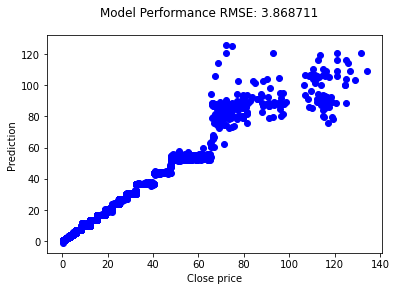

RMSE: 3.8687109460553692


In [19]:

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(dataset)

rfResult = rfPred.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Close price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

print("RMSE:",rmse)

#### Best Model
To get the best model we need to obtain from pipeline. First VectorFeatures, second model. 

In [20]:
bestModel_Pipeline = cvModel.bestModel
bestModel = bestModel_Pipeline.stages[1]

In [21]:
bestModel.getMaxDepth()

5

In [22]:
bestModel.getMaxIter()

10

In [23]:
bestModel.getMaxBins()

32

### Feature Importance for gradient boosting regressor

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Text(0.5, 1.0, 'Feature Importances')

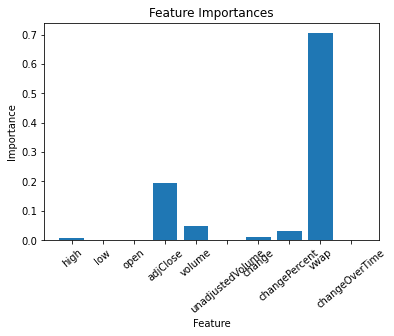

In [24]:
# Extract the important feature values
importances = bestModel.featureImportances

x_values = list(range(len(importances)))
print(x_values)
feature_list = ['high','low','open','adjClose','volume','unadjustedVolume','change','changePercent','vwap','changeOverTime']

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')